In [ ]:
import sys
import numpy as np
import cv2
import cv2.ml
from time import sleep
import pytz
from datetime import datetime
from pysolar import solar
import os
import numpy as np
from random import shuffle
from matplotlib import pyplot as plt
import matplotlib as mpl
import pandas as pd
from pandas import read_csv, read_excel, DataFrame
from skimage.feature import hessian_matrix_det as Hessian
from skimage.feature import local_binary_pattern as LBP
import pickle
import logging
logging.basicConfig(level=logging.INFO)

#p0 = os.path.join('../../','raw','CookIRCamET','Images','CookHY2023')
#p00 = os.path.join('../../','raw','CookIRCamET','Images','CprlHY2023')
p0 = os.path.join('E:/usda','raw','CookIRCamET','Images','CookHY2023')
p00 = os.path.join('E:/usda','raw','CookIRCamET','Images','CprlHY2023')
p3 = os.path.join('../../','work','CookIRCamET','Working')
n_components1 = 2
n_components2 = 4
n_components3 = 8
plots = False

# In[2]:

cmap3 = mpl.colors.ListedColormap(['y', 'r', 'g','w','b','m','c','k'])
norm3 = mpl.colors.BoundaryNorm([0,1,2,3,4,5,6,7,8], cmap3.N)

In [ ]:
model_mlp3_v1 = pickle.load(open(os.path.join(p3,'finalized_model3_mlp.pk.sav'), 'rb'))
scaler_v1 = pickle.load(open(os.path.join(p3,'scaler_mlp.pk.sav'), 'rb'))
model_mlp3_v2 = pickle.load(open(os.path.join(p3,'finalized_model3_mlp_v2.pk.sav'), 'rb'))
scaler_v2 = pickle.load(open(os.path.join(p3,'scaler_mlp_v2.pk.sav'), 'rb'))

cal_nsar_v0 = pickle.load(open(os.path.join(p3,'calibration_nsar1.pk.sav'), 'rb'))#20220705
cal_nsar_v1 = pickle.load(open(os.path.join(p3,'calibration_nsar2.pk.sav'), 'rb'))#20221122
cal_nsar_v2 = pickle.load(open(os.path.join(p3,'calibration_nsar3.pk.sav'), 'rb'))#20230315
cal_cprl = pickle.load(open(os.path.join(p3,'calibration_cprl1.pk.sav'), 'rb'))#20230305

In [ ]:
def localSD(mat, n):    
    mat=np.float32(mat)
    mu = cv2.blur(mat,(n,n))
    mdiff=mu-mat
    mat2=cv2.blur(np.float64(mdiff*mdiff),(n,n))
    sd = np.float32(cv2.sqrt(mat2))
    
    return sd

In [ ]:
def quadrant(img_size,coord):
    if coord[0]>img_size[1]/2 and coord[1]>img_size[0]/2:
        return 1
    elif coord[0]>img_size[1]/2 and coord[1]<=img_size[0]/2:
        return 4
    elif coord[0]<=img_size[1]/2 and coord[1]>img_size[0]/2:
        return 2
    else:
        return 3

In [ ]:
def register_ir(ir,v,bgr,warp_mat=None):
    # plt.imshow(v)
    # plt.title('v')
    # plt.colorbar()
    # plt.show()     
    # plt.imshow(ir)
    # plt.title('ir')
    # plt.colorbar()
    # plt.show()     

    dilate_v=True
    dilate_ir=False
    erode_v=True
    erode_ir=False
    hough_thresh_ir=36
    if v.shape[1]==1280:
        hough_thresh_v=240    
    elif v.shape[1]==1920:
        hough_thresh_v=360
    if warp_mat is None:
        print('Calculate affine')
        srcXY, dstXY = [], []
        cv2.normalize(ir, ir, 0, 65535, cv2.NORM_MINMAX)
        cv2.normalize(v, v, 0, 255, cv2.NORM_MINMAX)

        ir=np.uint8(np.right_shift(ir, 8, ir))

        # Otsu's thresholding
        xwin = int(v.shape[1]/(1280/240))+1
        C=-50
        if v.shape[1]==1920: C=-87
        # print(xwin,C)
        # print(v.shape)
        v = cv2.adaptiveThreshold(v,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,xwin,C)
        #_,v = cv2.threshold(v,245,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        ir = cv2.adaptiveThreshold(ir,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY_INV,41,50)
        #_,ir = cv2.threshold(ir,137,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
        erodewin = int(1920/(1280/2))+1
        if erode_v:
            kernel = np.ones((erodewin,erodewin),np.uint8)
            v = cv2.erode(v,kernel,iterations = 1)

        if erode_ir:    
            kernel = np.ones((erodewin,erodewin),np.uint8)
            ir = cv2.erode(ir,kernel,iterations = 1)

        if dilate_v:
            kernel = np.ones((erodewin,erodewin),np.uint8)
            v = cv2.dilate(v,kernel,iterations = 1)

        if dilate_ir:
            kernel = np.ones((erodewin,erodewin),np.uint8)
            ir = cv2.dilate(ir,kernel,iterations = 1)
        
        plt.imshow(v)
        plt.title('v')
        plt.show()     
        plt.imshow(ir)
        plt.title('ir')
        plt.show()     

        line_params_v={'slope':[],'intercept':[]}
        lines_v = cv2.HoughLines(v,1,np.pi/180,hough_thresh_v)
        slope = np.zeros(lines_v.shape[0])
        intercept = np.zeros(lines_v.shape[0])
        four_v = np.zeros((lines_v.shape[0],4))
        ii = 0
        for line in lines_v:
            rho,theta = line[0]
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a*rho
            y0 = b*rho
            x1 = int(x0 + v.shape[1]*(-b))
            y1 = int(y0 + v.shape[1]*(a))
            x2 = int(x0 - v.shape[1]*(-b))
            y2 = int(y0 - v.shape[1]*(a))
            cv2.line(bgr,(x1,y1),(x2,y2),(0,0,255),2)
            four_v[ii,:]=np.array([x1,y1,x2,y2])
            if x2==x1:
                slope[ii]=(y2-y1)/(x2-x1+.0000001*np.random.randn(1))
            else:
                slope[ii]=(y2-y1)/(x2-x1)
            intercept[ii]=(y2-slope[ii]*x2)
            ii = ii+1

        line_params_v['slope']=slope
        line_params_v['intercept']=intercept

        lines_ir = cv2.HoughLines(ir,1,np.pi/180,hough_thresh_ir)
        line_params_ir={'slope':[],'intercept':[]}
        slope = np.zeros(lines_ir.shape[0])
        intercept = np.zeros(lines_ir.shape[0])
        four_ir = np.zeros((lines_ir.shape[0],4))
        ii = 0
        for line in lines_ir:
            rho,theta = line[0]
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a*rho
            y0 = b*rho
            x1 = int(x0 + 200*(-b))
            y1 = int(y0 + 200*(a))
            x2 = int(x0 - 200*(-b))
            y2 = int(y0 - 200*(a))
            cv2.line(bgr,(x1,y1),(x2,y2),(255,0,0),2)
            four_ir[ii,:]=np.array([x1,y1,x2,y2])
            if x2==x1:
                slope[ii]=(y2-y1)/(x2-x1+.0000001*np.random.randn(1))
            else:
                slope[ii]=(y2-y1)/(x2-x1)
            intercept[ii]=(y2-slope[ii]*x2)
            ii = ii+1
        line_params_ir['slope']=slope
        line_params_ir['intercept']=intercept

        n = line_params_v['slope'].shape[0]
        combos = int((n*(n-1))/2)
        corner_v = np.zeros((combos,2))
        kk = 0
        for ii in range(line_params_v['slope'].shape[0]):
            for jj in range(ii,line_params_v['slope'].shape[0]):
                if ii!=jj:
                    if np.abs(np.abs(line_params_v['slope'][ii])*np.abs(line_params_v['slope'][jj])-1)<.1:
                        x = (line_params_v['intercept'][jj]-line_params_v['intercept'][ii])/(line_params_v['slope'][ii]-line_params_v['slope'][jj])
                        y = line_params_v['slope'][ii]*x+line_params_v['intercept'][ii]
                        corner_v[kk,0] = x
                        corner_v[kk,1] = y
                        kk = kk+1
                        try:
                            cv2.circle(bgr, (int(x),int(y)), radius=3, color=(0, 0, 0), thickness=-1)
                        except:
                            pass
                    else:
                        x = np.nan
                        y = np.nan
                        corner_v[kk,0] = x
                        corner_v[kk,1] = y
                        kk = kk+1
        n = line_params_ir['slope'].shape[0]
        combos = int((n*(n-1))/2)
        corner_ir = np.zeros((combos,2))
        kk = 0
        for ii in range(line_params_ir['slope'].shape[0]):
            for jj in range(ii,line_params_ir['slope'].shape[0]):
                if ii!=jj:
                    if np.abs(np.abs(line_params_ir['slope'][ii])*np.abs(line_params_ir['slope'][jj])-1)<.1:
                        x = (line_params_ir['intercept'][jj]-line_params_ir['intercept'][ii])/(line_params_ir['slope'][ii]-line_params_ir['slope'][jj])
                        y = line_params_ir['slope'][ii]*x+line_params_ir['intercept'][ii]
                        corner_ir[kk,0] = x
                        corner_ir[kk,1] = y
                        kk = kk+1
                        try:
                            cv2.circle(bgr, (int(x),int(y)), radius=3, color=(255, 255, 255), thickness=-1)
                        except:
                            pass
                    else:
                        x = np.nan
                        y = np.nan
                        corner_ir[kk,0] = x
                        corner_ir[kk,1] = y
                        kk = kk+1

        corner_ir = corner_ir[np.argwhere(np.isnan(corner_ir[:,0])==False)[:,0],]
        corner_v = corner_v[np.argwhere(np.isnan(corner_v[:,0])==False)[:,0],]

       
        plt.imshow(bgr)
        plt.show()     
        plt.imshow(ir)
        plt.show()     

        q_v = np.zeros(corner_v.shape[0])
        q_ir = np.zeros(corner_ir.shape[0])
        for ii in range(corner_v.shape[0]):
            q_v[ii] = quadrant(bgr.shape[0:2],corner_v[ii,:])    
        for jj in range(corner_ir.shape[0]):
            q_ir[jj] = quadrant(ir.shape[0:2],corner_ir[jj,:])

        q_list=list()
        for ii in range(corner_v.shape[0]):
            for jj in range(corner_ir.shape[0]):
                if q_v[ii]==q_ir[jj]:
                    srcXY.append(corner_ir[jj,:])
                    dstXY.append(corner_v[ii,:])
                    q_list.append(q_v[ii])
                    
        srcXY = np.float32(np.array(srcXY))
        dstXY = np.float32(np.array(dstXY))
        q_list = np.float32(np.array(q_list))
        
        src = np.zeros((4,2))
        dst = np.zeros((4,2))
        
        for i in range(4):
            src[i,:] = np.mean(srcXY[q_list==i+1,:],axis=0)
            dst[i,:] = np.mean(dstXY[q_list==i+1,:],axis=0)
        warp_mat = cv2.estimateAffine2D(src,dst)
        warp_dst = None
    else:
        print('Apply affine')
        warp_dst = cv2.warpAffine(ir, warp_mat[0], (v.shape[1], v.shape[0]),flags=cv2.INTER_NEAREST)   
    return warp_mat, warp_dst

2022-10-28 22:42:15+00:00
Calculate affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)


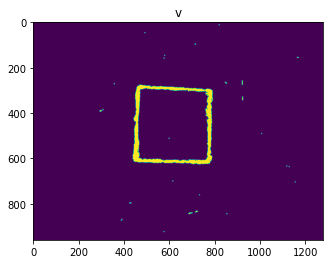

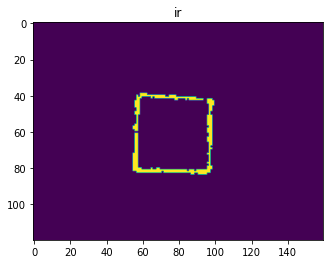

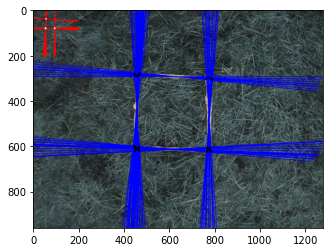

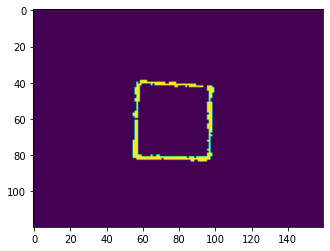

C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:413: RuntimeWarning: Mean of empty slice
  T_snw_sun.append(np.nanmean(T_ir[pred_mlp3==3]))
C:\Users\joaquin\AppDat

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: RuntimeWarning: Mean of empty slice
  T_res_shd.append(np.nanmean(T_ir[[pred_mlp3==5] or [pred_mlp3==1]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:471: RuntimeWarning: Mean of empty slice
  T_veg_shd.append(np.nanmean(T_ir[[pred_mlp3==6] or [pred_mlp3==2]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:473: RuntimeWarning: Mean of empty slice
  T_snw_shd.append(np.nanmean(T_ir[[pred_mlp3==7] or [pred_mlp3==3]]))


Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:446: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: RuntimeWarning: Mean of empty slice
  T_res_shd.append(np.nanmean(T_ir[[pred_mlp3==5] or [pred_mlp3==1]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:471: RuntimeWarning: Mean of empty slice
  T_veg_shd.append(np.nanmean(T_ir[[pred_mlp3==6] or [pred_mlp3==2]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:473: RuntimeWarning: Mean of empty slice
  T_snw_shd.append(np.nanmean(T_ir[[pred_mlp3==7] or [pred_mlp3==3]]))


Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:410: RuntimeWarning: Mean of empty slice
  T_res_shd.append(np.nanmean(T_ir[pred_mlp3==5]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:411: RuntimeWarning: Mean of empty slice
  T_veg_sun.append(np.nanmean(T_ir[pred_mlp3==2]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:412: RuntimeWarning: Mean of empty slice
  T_veg_shd.append(np.nanmean(T_ir[pred_mlp3==6]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: RuntimeWarning: Mean of empty slice
  T_res_shd.append(np.nanmean(T_ir[[pred_mlp3==5] or [pred_mlp3==1]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:471: RuntimeWarning: Mean of empty slice
  T_veg_shd.append(np.nanmean(T_ir[[pred_mlp3==6] or [pred_mlp3==2]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:473: RuntimeWarning: Mean of empty slice
  T_snw_shd.append(np.nanmean(T_ir[[pred_mlp3==7] or [pred_mlp3==3]]))


Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

2022-11-08 18:01:52+00:00
Calculate affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)


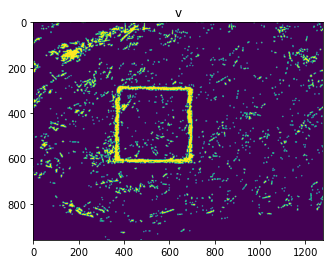

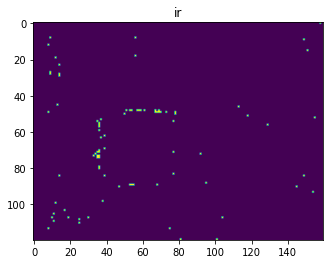

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:413: RuntimeWarning: Mean of empty slice
  T_snw_sun.append(np.nanmean(T_ir[pred_mlp3==3]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:414: RuntimeWarning: Mean of empty slice
  T_snw_shd.append(np.nanmean(T_ir[pred_mlp3==7]))
C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/30606

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: RuntimeWarning: Mean of empty slice
  T_res_shd.append(np.nanmean(T_ir[[pred_mlp3==5] or [pred_mlp3==1]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:471: RuntimeWarning: Mean of empty slice
  T_veg_shd.append(np.nanmean(T_ir[[pred_mlp3==6] or [pred_mlp3==2]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:473: RuntimeWarning: Mean of empty slice
  T_snw_shd.append(np.nanmean(T_ir[[pred_mlp3==7] or [pred_mlp3==3]]))


Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: RuntimeWarning: Mean of empty slice
  T_res_shd.append(np.nanmean(T_ir[[pred_mlp3==5] or [pred_mlp3==1]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:471: RuntimeWarning: Mean of empty slice
  T_veg_shd.append(np.nanmean(T_ir[[pred_mlp3==6] or [pred_mlp3==2]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:473: RuntimeWarning: Mean of empty slice
  T_snw_shd.append(np.nanmean(T_ir[[pred_mlp3==7] or [pred_mlp3==3]]))


Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: RuntimeWarning: Mean of empty slice
  T_res_shd.append(np.nanmean(T_ir[[pred_mlp3==5] or [pred_mlp3==1]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:471: RuntimeWarning: Mean of empty slice
  T_veg_shd.append(np.nanmean(T_ir[[pred_mlp3==6] or [pred_mlp3==2]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:473: RuntimeWarning: Mean of empty slice
  T_snw_shd.append(np.nanmean(T_ir[[pred_mlp3==7] or [pred_mlp3==3]]))


Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: RuntimeWarning: Mean of empty slice
  T_res_shd.append(np.nanmean(T_ir[[pred_mlp3==5] or [pred_mlp3==1]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:471: RuntimeWarning: Mean of empty slice
  T_veg_shd.append(np.nanmean(T_ir[[pred_mlp3==6] or [pred_mlp3==2]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:473: RuntimeWarning: Mean of empty slice
  T_snw_shd.append(np.nanmean(T_ir[[pred_mlp3==7] or [pred_mlp3==3]]))


Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: RuntimeWarning: Mean of empty slice
  T_res_shd.append(np.nanmean(T_ir[[pred_mlp3==5] or [pred_mlp3==1]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:471: RuntimeWarning: Mean of empty slice
  T_veg_shd.append(np.nanmean(T_ir[[pred_mlp3==6] or [pred_mlp3==2]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:473: RuntimeWarning: Mean of empty slice
  T_snw_shd.append(np.nanmean(T_ir[[pred_mlp3==7] or [pred_mlp3==3]]))


Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: RuntimeWarning: Mean of empty slice
  T_res_shd.append(np.nanmean(T_ir[[pred_mlp3==5] or [pred_mlp3==1]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:471: RuntimeWarning: Mean of empty slice
  T_veg_shd.append(np.nanmean(T_ir[[pred_mlp3==6] or [pred_mlp3==2]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:473: RuntimeWarning: Mean of empty slice
  T_snw_shd.append(np.nanmean(T_ir[[pred_mlp3==7] or [pred_mlp3==3]]))


Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: RuntimeWarning: Mean of empty slice
  T_res_shd.append(np.nanmean(T_ir[[pred_mlp3==5] or [pred_mlp3==1]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:471: RuntimeWarning: Mean of empty slice
  T_veg_shd.append(np.nanmean(T_ir[[pred_mlp3==6] or [pred_mlp3==2]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:473: RuntimeWarning: Mean of empty slice
  T_snw_shd.append(np.nanmean(T_ir[[pred_mlp3==7] or [pred_mlp3==3]]))


Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:446: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  T_sol_shd.append(np.nanme

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: RuntimeWarning: Mean of empty slice
  T_res_shd.append(np.nanmean(T_ir[[pred_mlp3==5] or [pred_mlp3==1]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:471: RuntimeWarning: Mean of empty slice
  T_veg_shd.append(np.nanmean(T_ir[[pred_mlp3==6] or [pred_mlp3==2]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:473: RuntimeWarning: Mean of empty slice
  T_snw_shd.append(np.nanmean(T_ir[[pred_mlp3==7] or [pred_mlp3==3]]))


Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: RuntimeWarning: Mean of empty slice
  T_res_shd.append(np.nanmean(T_ir[[pred_mlp3==5] or [pred_mlp3==1]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:471: RuntimeWarning: Mean of empty slice
  T_veg_shd.append(np.nanmean(T_ir[[pred_mlp3==6] or [pred_mlp3==2]]))


Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: RuntimeWarning: Mean of empty slice
  T_res_shd.append(np.nanmean(T_ir[[pred_mlp3==5] or [pred_mlp3==1]]))


Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))


Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:410: RuntimeWarning: Mean of empty slice
  T_res_shd.append(np.nanmean(T_ir[pred_mlp3==5]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:411: RuntimeWarning: Mean of empty slice
  T_veg_sun.append(np.nanmean(T_ir[pred_mlp3==2]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:412: RuntimeWarning: Mean of empty slice
  T_veg_shd.append(np.nanmean(T_ir[pred_mlp3==6]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:

Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:446: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: FutureWarning: Using a non-tuple sequence for m

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:413: RuntimeWarning: Mean of empty slice
  T_snw_sun.append(np.nanmean(T_ir[pred_mlp3==3]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:413: RuntimeWarning: Mean of empty slice
  T_snw_sun.append(np.nanmean(T_ir[pred_mlp3==3]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance

Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: RuntimeWarning: Mean of empty slice
  T_res_shd.append(np.nanmean(T_ir[[pred_mlp3==5] or [pred_mlp3==1]]))


Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: RuntimeWarning: Mean of empty slice
  T_res_shd.append(np.nanmean(T_ir[[pred_mlp3==5] or [pred_mlp3==1]]))


Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:410: RuntimeWarning: Mean of empty slice
  T_res_shd.append(np.nanmean(T_ir[pred_mlp3==5]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:411: RuntimeWarning: Mean of empty slice
  T_veg_sun.append(np.nanmean(T_ir[pred_mlp3==2]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:413: RuntimeWarning: Mean of empty slice
  T_snw_sun.append(np.nanmean(T_ir[pred_mlp3==3]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: RuntimeWarning: Mean of empty slice
  T_res_shd.append(np.nanmean(T_ir[[pred_mlp3==5] or [pred_mlp3==1]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:471: RuntimeWarning: Mean of empty slice
  T_veg_shd.append(np.nanmean(T_ir[[pred_mlp3==6] or [pred_mlp3==2]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:473: RuntimeWarning: Mean of empty slice
  T_snw_shd.append(np.nanmean(T_ir[[pred_mlp3==7] or [pred_mlp3==3]]))


Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: RuntimeWarning: Mean of empty slice
  T_res_shd.append(np.nanmean(T_ir[[pred_mlp3==5] or [pred_mlp3==1]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:471: RuntimeWarning: Mean of empty slice
  T_veg_shd.append(np.nanmean(T_ir[[pred_mlp3==6] or [pred_mlp3==2]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:473: RuntimeWarning: Mean of empty slice
  T_snw_shd.append(np.nanmean(T_ir[[pred_mlp3==7] or [pred_mlp3==3]]))


Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))


Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: RuntimeWarning: Mean of empty slice
  T_res_shd.append(np.nanmean(T_ir[[pred_mlp3==5] or [pred_mlp3==1]]))


Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:446: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:446: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:410: RuntimeWarning: Mean of empty slice
  T_res_shd.append(np.nanmean(T_ir[pred_mlp3==5]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:411: RuntimeWarning: Mean of empty slice
  T_veg_sun.append(np.nanmean(T_ir[pred_mlp3==2]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:412: RuntimeWarning: Mean of empty slice
  T_veg_shd.append(np.nanmean(T_ir[pred_mlp3==6]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:

Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: RuntimeWarning: Mean of empty slice
  T_res_shd.append(np.nanmean(T_ir[[pred_mlp3==5] or [pred_mlp3==1]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:471: RuntimeWarning: Mean of empty slice
  T_veg_shd.append(np.nanmean(T_ir[[pred_mlp3==6] or [pred_mlp3==2]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:473: RuntimeWarning: Mean of empty slice
  T_snw_shd.append(np.nanmean(T_ir[[pred_mlp3==7] or [pred_mlp3==3]]))


Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: RuntimeWarning: Mean of empty slice
  T_res_shd.append(np.nanmean(T_ir[[pred_mlp3==5] or [pred_mlp3==1]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:471: RuntimeWarning: Mean of empty slice
  T_veg_shd.append(np.nanmean(T_ir[[pred_mlp3==6] or [pred_mlp3==2]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:473: RuntimeWarning: Mean of empty slice
  T_snw_shd.append(np.nanmean(T_ir[[pred_mlp3==7] or [pred_mlp3==3]]))


Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: RuntimeWarning: Mean of empty slice
  T_res_shd.append(np.nanmean(T_ir[[pred_mlp3==5] or [pred_mlp3==1]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:471: RuntimeWarning: Mean of empty slice
  T_veg_shd.append(np.nanmean(T_ir[[pred_mlp3==6] or [pred_mlp3==2]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:473: RuntimeWarning: Mean of empty slice
  T_snw_shd.append(np.nanmean(T_ir[[pred_mlp3==7] or [pred_mlp3==3]]))


Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:410: RuntimeWarning: Mean of empty slice
  T_res_shd.append(np.nanmean(T_ir[pred_mlp3==5]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:413: RuntimeWarning: Mean of empty slice
  T_snw_sun.append(np.nanmean(T_ir[pred_mlp3==3]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:414: RuntimeWarning: Mean of empty slice
  T_snw_shd.append(np.nanmean(T_ir[pred_mlp3==7]))


Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: RuntimeWarning: Mean of empty slice
  T_res_shd.append(np.nanmean(T_ir[[pred_mlp3==5] or [pred_mlp3==1]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:473: RuntimeWarning: Mean of empty slice
  T_snw_shd.append(np.nanmean(T_ir[[pred_mlp3==7] or [pred_mlp3==3]]))


Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: RuntimeWarning: Mean of empty slice
  T_res_shd.append(np.nanmean(T_ir[[pred_mlp3==5] or [pred_mlp3==1]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:471: RuntimeWarning: Mean of empty slice
  T_veg_shd.append(np.nanmean(T_ir[[pred_mlp3==6] or [pred_mlp3==2]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:473: RuntimeWarning: Mean of empty slice
  T_snw_shd.append(np.nanmean(T_ir[[pred_mlp3==7] or [pred_mlp3==3]]))


Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: RuntimeWarning: Mean of empty slice
  T_res_shd.append(np.nanmean(T_ir[[pred_mlp3==5] or [pred_mlp3==1]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:471: RuntimeWarning: Mean of empty slice
  T_veg_shd.append(np.nanmean(T_ir[[pred_mlp3==6] or [pred_mlp3==2]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:473: RuntimeWarning: Mean of empty slice
  T_snw_shd.append(np.nanmean(T_ir[[pred_mlp3==7] or [pred_mlp3==3]]))


Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:446: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  T_sol_shd.append(np.nanme

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: RuntimeWarning: Mean of empty slice
  T_res_shd.append(np.nanmean(T_ir[[pred_mlp3==5] or [pred_mlp3==1]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:471: RuntimeWarning: Mean of empty slice
  T_veg_shd.append(np.nanmean(T_ir[[pred_mlp3==6] or [pred_mlp3==2]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:473: RuntimeWarning: Mean of empty slice
  T_snw_shd.append(np.nanmean(T_ir[[pred_mlp3==7] or [pred_mlp3==3]]))


Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:446: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: FutureWarning: Using a non-tuple sequence for m

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:446: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  T_sol_shd.append(np.nanme

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: RuntimeWarning: Mean of empty slice
  T_res_shd.append(np.nanmean(T_ir[[pred_mlp3==5] or [pred_mlp3==1]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:471: RuntimeWarning: Mean of empty slice
  T_veg_shd.append(np.nanmean(T_ir[[pred_mlp3==6] or [pred_mlp3==2]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:473: RuntimeWarning: Mean of empty slice
  T_snw_shd.append(np.nanmean(T_ir[[pred_mlp3==7] or [pred_mlp3==3]]))


Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:446: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: FutureWarning: Using a non-tuple sequence for m

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: RuntimeWarning: Mean of empty slice
  T_res_shd.append(np.nanmean(T_ir[[pred_mlp3==5] or [pred_mlp3==1]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:471: RuntimeWarning: Mean of empty slice
  T_veg_shd.append(np.nanmean(T_ir[[pred_mlp3==6] or [pred_mlp3==2]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:473: RuntimeWarning: Mean of empty slice
  T_snw_shd.append(np.nanmean(T_ir[[pred_mlp3==7] or [pred_mlp3==3]]))


Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\j

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:446: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  T_sol_shd.append(np.nanme

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\j

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array 

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\j

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\j

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  T_res_shd.append(np.nanmean(T_ir[[pred_mlp3==5] or [pred_mlp3==1]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:471: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  T_veg_shd.append(np.nanmean(T_ir[[pred_mlp3==6] or [pred_mlp3==2]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:473: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: RuntimeWarning: Mean of empty slice
  T_res_shd.append(np.nanmean(T_ir[[pred_mlp3==5] or [pred_mlp3==1]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:471: RuntimeWarning: Mean of empty slice
  T_veg_shd.append(np.nanmean(T_ir[[pred_mlp3==6] or [pred_mlp3==2]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:473: RuntimeWarning: Mean of empty slice
  T_snw_shd.append(np.nanmean(T_ir[[pred_mlp3==7] or [pred_mlp3==3]]))


Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:446: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  T_sol_shd.append(np.nanme

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: RuntimeWarning: Mean of empty slice
  T_res_shd.append(np.nanmean(T_ir[[pred_mlp3==5] or [pred_mlp3==1]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:471: RuntimeWarning: Mean of empty slice
  T_veg_shd.append(np.nanmean(T_ir[[pred_mlp3==6] or [pred_mlp3==2]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:473: RuntimeWarning: Mean of empty slice
  T_snw_shd.append(np.nanmean(T_ir[[pred_mlp3==7] or [pred_mlp3==3]]))


Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: RuntimeWarning: Mean of empty slice
  T_res_shd.append(np.nanmean(T_ir[[pred_mlp3==5] or [pred_mlp3==1]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:471: RuntimeWarning: Mean of empty slice
  T_veg_shd.append(np.nanmean(T_ir[[pred_mlp3==6] or [pred_mlp3==2]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:473: RuntimeWarning: Mean of empty slice
  T_snw_shd.append(np.nanmean(T_ir[[pred_mlp3==7] or [pred_mlp3==3]]))


Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array 

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: RuntimeWarning: Mean of empty slice
  T_res_shd.append(np.nanmean(T_ir[[pred_mlp3==5] or [pred_mlp3==1]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:471: RuntimeWarning: Mean of empty slice
  T_veg_shd.append(np.nanmean(T_ir[[pred_mlp3==6] or [pred_mlp3==2]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:473: RuntimeWarning: Mean of empty slice
  T_snw_shd.append(np.nanmean(T_ir[[pred_mlp3==7] or [pred_mlp3==3]]))


Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
Apply affine
Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:446: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  T_sol_shd.append(np.nanme

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: RuntimeWarning: Mean of empty slice
  T_res_shd.append(np.nanmean(T_ir[[pred_mlp3==5] or [pred_mlp3==1]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:471: RuntimeWarning: Mean of empty slice
  T_veg_shd.append(np.nanmean(T_ir[[pred_mlp3==6] or [pred_mlp3==2]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:473: RuntimeWarning: Mean of empty slice
  T_snw_shd.append(np.nanmean(T_ir[[pred_mlp3==7] or [pred_mlp3==3]]))


Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:446: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: FutureWarning: Using a non-tuple sequence for m

Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: RuntimeWarning: Mean of empty slice
  T_res_shd.append(np.nanmean(T_ir[[pred_mlp3==5] or [pred_mlp3==1]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:471: RuntimeWarning: Mean of empty slice
  T_veg_shd.append(np.nanmean(T_ir[[pred_mlp3==6] or [pred_mlp3==2]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:473: RuntimeWarning: Mean of empty slice
  T_snw_shd.append(np.nanmean(T_ir[[pred_mlp3==7] or [pred_mlp3==3]]))


Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:446: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: FutureWarning: Using a non-tuple sequence for m

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\j

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: RuntimeWarning: Mean of empty slice
  T_res_shd.append(np.nanmean(T_ir[[pred_mlp3==5] or [pred_mlp3==1]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:471: RuntimeWarning: Mean of empty slice
  T_veg_shd.append(np.nanmean(T_ir[[pred_mlp3==6] or [pred_mlp3==2]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:473: RuntimeWarning: Mean of empty slice
  T_snw_shd.append(np.nanmean(T_ir[[pred_mlp3==7] or [pred_mlp3==3]]))


Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\j

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:446: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  T_sol_shd.append(np.nanme

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: RuntimeWarning: Mean of empty slice
  T_res_shd.append(np.nanmean(T_ir[[pred_mlp3==5] or [pred_mlp3==1]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:471: RuntimeWarning: Mean of empty slice
  T_veg_shd.append(np.nanmean(T_ir[[pred_mlp3==6] or [pred_mlp3==2]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:473: RuntimeWarning: Mean of empty slice
  T_snw_shd.append(np.nanmean(T_ir[[pred_mlp3==7] or [pred_mlp3==3]]))


Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:446: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: FutureWarning: Using a non-tuple sequence for m

Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: RuntimeWarning: Mean of empty slice
  T_res_shd.append(np.nanmean(T_ir[[pred_mlp3==5] or [pred_mlp3==1]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:471: RuntimeWarning: Mean of empty slice
  T_veg_shd.append(np.nanmean(T_ir[[pred_mlp3==6] or [pred_mlp3==2]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:473: RuntimeWarning: Mean of empty slice
  T_snw_shd.append(np.nanmean(T_ir[[pred_mlp3==7] or [pred_mlp3==3]]))


Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\j

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\j

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:446: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  T_sol_shd.append(np.nanme

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: RuntimeWarning: Mean of empty slice
  T_res_shd.append(np.nanmean(T_ir[[pred_mlp3==5] or [pred_mlp3==1]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:471: RuntimeWarning: Mean of empty slice
  T_veg_shd.append(np.nanmean(T_ir[[pred_mlp3==6] or [pred_mlp3==2]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:473: RuntimeWarning: Mean of empty slice
  T_snw_shd.append(np.nanmean(T_ir[[pred_mlp3==7] or [pred_mlp3==3]]))


Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  T_res_shd.append(np.nanmean(T_ir[[pred_mlp3==5] or [pred_mlp3==1]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: RuntimeWarning: Mean of empty slice
  T_res_shd.append(np.nanmean(T_ir[[pred_mlp3==5] or [pred_mlp3==1]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:471: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpre

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: RuntimeWarning: Mean of empty slice
  T_res_shd.append(np.nanmean(T_ir[[pred_mlp3==5] or [pred_mlp3==1]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:471: RuntimeWarning: Mean of empty slice
  T_veg_shd.append(np.nanmean(T_ir[[pred_mlp3==6] or [pred_mlp3==2]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:473: RuntimeWarning: Mean of empty slice
  T_snw_shd.append(np.nanmean(T_ir[[pred_mlp3==7] or [pred_mlp3==3]]))


Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:446: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: FutureWarning: Using a non-tuple sequence for m

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:446: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: FutureWarning: Using a non-tuple sequence for m

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: RuntimeWarning: Mean of empty slice
  T_res_shd.append(np.nanmean(T_ir[[pred_mlp3==5] or [pred_mlp3==1]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:471: RuntimeWarning: Mean of empty slice
  T_veg_shd.append(np.nanmean(T_ir[[pred_mlp3==6] or [pred_mlp3==2]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:473: RuntimeWarning: Mean of empty slice
  T_snw_shd.append(np.nanmean(T_ir[[pred_mlp3==7] or [pred_mlp3==3]]))


Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:446: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: FutureWarning: Using a non-tuple sequence for m

Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: RuntimeWarning: Mean of empty slice
  T_res_shd.append(np.nanmean(T_ir[[pred_mlp3==5] or [pred_mlp3==1]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:471: RuntimeWarning: Mean of empty slice
  T_veg_shd.append(np.nanmean(T_ir[[pred_mlp3==6] or [pred_mlp3==2]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:473: RuntimeWarning: Mean of empty slice
  T_snw_shd.append(np.nanmean(T_ir[[pred_mlp3==7] or [pred_mlp3==3]]))


Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine
Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:446: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  T_sol_shd.append(np.nanme

Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: RuntimeWarning: Mean of empty slice
  T_res_shd.append(np.nanmean(T_ir[[pred_mlp3==5] or [pred_mlp3==1]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:471: RuntimeWarning: Mean of empty slice
  T_veg_shd.append(np.nanmean(T_ir[[pred_mlp3==6] or [pred_mlp3==2]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:473: RuntimeWarning: Mean of empty slice
  T_snw_shd.append(np.nanmean(T_ir[[pred_mlp3==7] or [pred_mlp3==3]]))


Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:446: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: FutureWarning: Using a non-tuple sequence for m

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: RuntimeWarning: Mean of empty slice
  T_res_shd.append(np.nanmean(T_ir[[pred_mlp3==5] or [pred_mlp3==1]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:471: RuntimeWarning: Mean of empty slice
  T_veg_shd.append(np.nanmean(T_ir[[pred_mlp3==6] or [pred_mlp3==2]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:473: RuntimeWarning: Mean of empty slice
  T_snw_shd.append(np.nanmean(T_ir[[pred_mlp3==7] or [pred_mlp3==3]]))


Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:446: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: FutureWarning: Using a non-tuple sequence for m

Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: RuntimeWarning: Mean of empty slice
  T_res_shd.append(np.nanmean(T_ir[[pred_mlp3==5] or [pred_mlp3==1]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:471: RuntimeWarning: Mean of empty slice
  T_veg_shd.append(np.nanmean(T_ir[[pred_mlp3==6] or [pred_mlp3==2]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:473: RuntimeWarning: Mean of empty slice
  T_snw_shd.append(np.nanmean(T_ir[[pred_mlp3==7] or [pred_mlp3==3]]))


Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:446: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: FutureWarning: Using a non-tuple sequence for m

Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: RuntimeWarning: Mean of empty slice
  T_res_shd.append(np.nanmean(T_ir[[pred_mlp3==5] or [pred_mlp3==1]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:471: RuntimeWarning: Mean of empty slice
  T_veg_shd.append(np.nanmean(T_ir[[pred_mlp3==6] or [pred_mlp3==2]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:473: RuntimeWarning: Mean of empty slice
  T_snw_shd.append(np.nanmean(T_ir[[pred_mlp3==7] or [pred_mlp3==3]]))


Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\j

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\j

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: RuntimeWarning: Mean of empty slice
  T_res_shd.append(np.nanmean(T_ir[[pred_mlp3==5] or [pred_mlp3==1]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:471: RuntimeWarning: Mean of empty slice
  T_veg_shd.append(np.nanmean(T_ir[[pred_mlp3==6] or [pred_mlp3==2]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:473: RuntimeWarning: Mean of empty slice
  T_snw_shd.append(np.nanmean(T_ir[[pred_mlp3==7] or [pred_mlp3==3]]))


Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\j

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:446: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  T_sol_shd.append(np.nanme

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\j

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\j

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  T_res_shd.append(np.nanmean(T_ir[[pred_mlp3==5] or [pred_mlp3==1]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: RuntimeWarning: Mean of empty slice
  T_res_shd.append(np.nanmean(T_ir[[pred_mlp3==5] or [pred_mlp3==1]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:471: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpre

Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:446: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\j

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:446: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: FutureWarning: Using a non-tuple sequence for m

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\j

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:446: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:446: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: FutureWarning: Using a non-tuple sequence for m

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:446: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: FutureWarning: Using a non-tuple sequence for m

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: RuntimeWarning: Mean of empty slice
  T_res_shd.append(np.nanmean(T_ir[[pred_mlp3==5] or [pred_mlp3==1]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:471: RuntimeWarning: Mean of empty slice
  T_veg_shd.append(np.nanmean(T_ir[[pred_mlp3==6] or [pred_mlp3==2]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:473: RuntimeWarning: Mean of empty slice
  T_snw_shd.append(np.nanmean(T_ir[[pred_mlp3==7] or [pred_mlp3==3]]))


Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  T_res_shd.append(np.nanmean(T_ir[[pred_mlp3==5] or [pred_mlp3==1]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: RuntimeWarning: Mean of empty slice
  T_res_shd.append(np.nanmean(T_ir[[pred_mlp3==5] or [pred_mlp3==1]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:471: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpre

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:473: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  T_snw_shd.append(np.nanmean(T_ir[[pred_mlp3==7] or [pred_mlp3==3]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))


Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: RuntimeWarning: Mean of empty slice
  T_res_shd.append(np.nanmean(T_ir[[pred_mlp3==5] or [pred_mlp3==1]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:471: RuntimeWarning: Mean of empty slice
  T_veg_shd.append(np.nanmean(T_ir[[pred_mlp3==6] or [pred_mlp3==2]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:473: RuntimeWarning: Mean of empty slice
  T_snw_shd.append(np.nanmean(T_ir[[pred_mlp3==7] or [pred_mlp3==3]]))


Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: RuntimeWarning: Mean of empty slice
  T_res_shd.append(np.nanmean(T_ir[[pred_mlp3==5] or [pred_mlp3==1]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:471: RuntimeWarning: Mean of empty slice
  T_veg_shd.append(np.nanmean(T_ir[[pred_mlp3==6] or [pred_mlp3==2]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:473: RuntimeWarning: Mean of empty slice
  T_snw_shd.append(np.nanmean(T_ir[[pred_mlp3==7] or [pred_mlp3==3]]))


Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  T_res_shd.append(np.nanmean(T_ir[[pred_mlp3==5] or [pred_mlp3==1]]))


Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  T_res_shd.append(np.nanmean(T_ir[[pred_mlp3==5] or [pred_mlp3==1]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:471: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  T_veg_shd.append(np.nanmean(T_ir[[pred_mlp3==6] or [pred_mlp3==2]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:473: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\j

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:446: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: FutureWarning: Using a non-tuple sequence for m

Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: RuntimeWarning: Mean of empty slice
  T_res_shd.append(np.nanmean(T_ir[[pred_mlp3==5] or [pred_mlp3==1]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:471: RuntimeWarning: Mean of empty slice
  T_veg_shd.append(np.nanmean(T_ir[[pred_mlp3==6] or [pred_mlp3==2]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:473: RuntimeWarning: Mean of empty slice
  T_snw_shd.append(np.nanmean(T_ir[[pred_mlp3==7] or [pred_mlp3==3]]))


Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:446: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  T_sol_shd.append(np.nanme

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\j

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\j

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array 

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array 

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:446: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  T_sol_shd.append(np.nanme

Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: RuntimeWarning: Mean of empty slice
  T_res_shd.append(np.nanmean(T_ir[[pred_mlp3==5] or [pred_mlp3==1]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:471: RuntimeWarning: Mean of empty slice
  T_veg_shd.append(np.nanmean(T_ir[[pred_mlp3==6] or [pred_mlp3==2]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:473: RuntimeWarning: Mean of empty slice
  T_snw_shd.append(np.nanmean(T_ir[[pred_mlp3==7] or [pred_mlp3==3]]))


Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\j

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\j

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:446: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: FutureWarning: Using a non-tuple sequence for m

Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: RuntimeWarning: Mean of empty slice
  T_res_shd.append(np.nanmean(T_ir[[pred_mlp3==5] or [pred_mlp3==1]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:471: RuntimeWarning: Mean of empty slice
  T_veg_shd.append(np.nanmean(T_ir[[pred_mlp3==6] or [pred_mlp3==2]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:473: RuntimeWarning: Mean of empty slice
  T_snw_shd.append(np.nanmean(T_ir[[pred_mlp3==7] or [pred_mlp3==3]]))


Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\j

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:446: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: FutureWarning: Using a non-tuple sequence for m

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: RuntimeWarning: Mean of empty slice
  T_res_shd.append(np.nanmean(T_ir[[pred_mlp3==5] or [pred_mlp3==1]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:471: RuntimeWarning: Mean of empty slice
  T_veg_shd.append(np.nanmean(T_ir[[pred_mlp3==6] or [pred_mlp3==2]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:473: RuntimeWarning: Mean of empty slice
  T_snw_shd.append(np.nanmean(T_ir[[pred_mlp3==7] or [pred_mlp3==3]]))


Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\j

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\j

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine
Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:446: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  T_sol_shd.append(np.nanme

Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: RuntimeWarning: Mean of empty slice
  T_res_shd.append(np.nanmean(T_ir[[pred_mlp3==5] or [pred_mlp3==1]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:471: RuntimeWarning: Mean of empty slice
  T_veg_shd.append(np.nanmean(T_ir[[pred_mlp3==6] or [pred_mlp3==2]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:473: RuntimeWarning: Mean of empty slice
  T_snw_shd.append(np.nanmean(T_ir[[pred_mlp3==7] or [pred_mlp3==3]]))


Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: RuntimeWarning: Mean of empty slice
  T_res_shd.append(np.nanmean(T_ir[[pred_mlp3==5] or [pred_mlp3==1]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:471: RuntimeWarning: Mean of empty slice
  T_veg_shd.append(np.nanmean(T_ir[[pred_mlp3==6] or [pred_mlp3==2]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:473: RuntimeWarning: Mean of empty slice
  T_snw_shd.append(np.nanmean(T_ir[[pred_mlp3==7] or [pred_mlp3==3]]))


Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:409: RuntimeWarning: Mean of empty slice
  T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
C:\Users\joaqu

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:407: RuntimeWarning: Mean of empty slice
  T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:408: RuntimeWarning: Mean of empty slice
  T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
C:\Users\j

Apply affine
Apply affine
Apply affine
Apply affine
2023-03-01 22:36:20+00:00
Calculate affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)


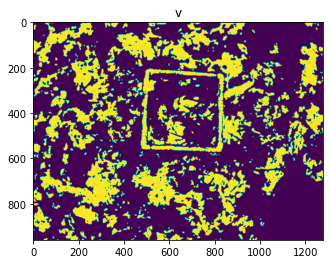

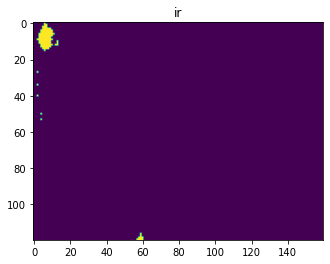

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:413: RuntimeWarning: Mean of empty slice
  T_snw_sun.append(np.nanmean(T_ir[pred_mlp3==3]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:414: RuntimeWarning: Mean of empty slice
  T_snw_shd.append(np.nanmean(T_ir[pred_mlp3==7]))
C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/30606

2023-03-20 17:13:23+00:00
Calculate affine


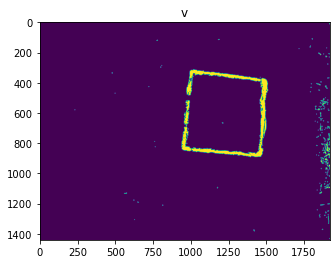

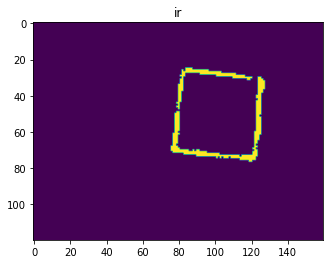

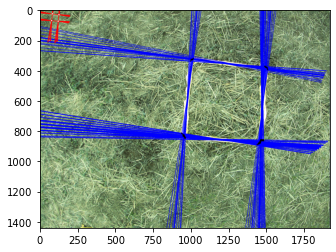

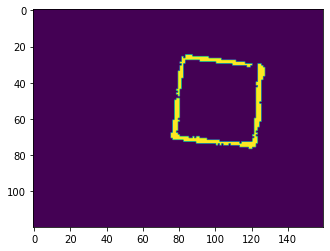

C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:413: RuntimeWarning: Mean of empty slice
  T_snw_sun.append(np.nanmean(T_ir[pred_mlp3==3]))
C:\Users\joaquin\AppDat

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:446: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: FutureWarning: Using a non-tuple sequence for m

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:446: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: FutureWarning: Using a non-tuple sequence for m

Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:414: RuntimeWarning: Mean of empty slice
  T_snw_shd.append(np.nanmean(T_ir[pred_mlp3==7]))
C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this war

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  T_res_shd.append(np.nanmean(T_ir[[pred_mlp3==5] or [pred_mlp3==1]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:471: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:446: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: FutureWarning: Using a non-tuple sequence for m

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:446: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: FutureWarning: Using a non-tuple sequence for m

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:446: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: FutureWarning: Using a non-tuple sequence for m

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  T_res_shd.append(np.nanmean(T_ir[[pred_mlp3==5] or [pred_mlp3==1]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:471: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:446: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: FutureWarning: Using a non-tuple sequence for m

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:446: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: FutureWarning: Using a non-tuple sequence for m

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:446: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: FutureWarning: Using a non-tuple sequence for m

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:446: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: FutureWarning: Using a non-tuple sequence for m

Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)


Apply affine


C:\Users\joaquin\anaconda3\envs\python-cv\lib\site-packages\pysolar\solartime.py:111: UserWarning: I don't know about leap seconds after 2021
  warnings.warn \
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
D

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:328: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:385: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\j

Apply affine
Apply affine


C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:446: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_ir = ir.astype(np.float)
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:467: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
C:\Users\joaquin\AppData\Local\Temp/ipykernel_4000/306066529.py:469: FutureWarning: Using a non-tuple sequence for m

In [121]:

start_dates_cook = ['20221028224215',
               '20221108180152',
               '20221125231429',
               '20221229191212',
               '20230301223610',
               '20230320171323',
               '20230522171148',
               '20230525222154',
               '20230601192831',
               '20230602184516']

stop_dates_cook =  ['20221104234238',
               '20221116210712',
               '20221229174156',
               '20230221015754',
               '20230301223630',
               '20230322045000',
               '20230525111517',
               '20230601022210',
               '20230602033124']
start_dates_cprl = ['20230411192131',
                    '20230427001305',
                    '20230607014817',
                    '20230623230336']

stop_dates_cprl =  ['20230426231253',
                    '20230531114644',
                    '20230623180307']

start_dates_cook = [pytz.utc.localize(datetime.strptime(d, '%Y%m%d%H%M%S')) for d in start_dates_cook]
stop_dates_cook = [pytz.utc.localize(datetime.strptime(d, '%Y%m%d%H%M%S')) for d in stop_dates_cook]

start_dates_cprl = [pytz.utc.localize(datetime.strptime(d, '%Y%m%d%H%M%S')) for d in start_dates_cprl]
stop_dates_cprl = [pytz.utc.localize(datetime.strptime(d, '%Y%m%d%H%M%S')) for d in stop_dates_cprl]

#for di, start_dates, stop_dates, cal_list in zip([p00,p0],[start_dates_cprl,start_dates_cook], [stop_dates_cprl, stop_dates_cook],[[cal_cprl,cal_cprl],[cal_nsar_v1,cal_nsar_v2]]):
for di, start_dates, stop_dates, cal_list in zip([p0],[start_dates_cook], [stop_dates_cook],[[cal_nsar_v1,cal_nsar_v2]]):
    pred_mlp3=None
    lat = np.nan
    lon = np.nan
    ti = 0
    ti_change = True
    imgs=[]
    f_sol_sun = []
    f_sol_shd = []
    f_res_sun = []
    f_res_shd = []
    f_veg_sun = []
    f_veg_shd = []
    f_snw_sun = []
    f_snw_shd = []

    T_sol_sun = []
    T_sol_shd = []
    T_res_sun = []
    T_res_shd = []
    T_veg_sun = []
    T_veg_shd = []
    T_snw_sun = []
    T_snw_shd = []

    elevation = []
    azimuth = []

    times = []

    n_img=0
 
    if di==p00:
        dstXY=np.array([[542,148],[1179.5,127.5],[1197.5,781.5],[533.5,783.5]])
        srcXY=np.array([[48,18],[105.5,17.5],[104.5,76.5],[47.5,76.5]])
        warp_mat = cv2.estimateAffine2D(srcXY,dstXY)
    elif di==p0:
        warp_mat = (np.array([[  7.88031998,   0.28718853,  -6.50989774],
        [  0.03765769,   7.90500728, -28.32654208]]),
 np.array([[1],
        [1],
        [1],
        [0]], dtype=np.uint8))
    #for version, model, scaler, cal in zip([,'V2'],[model_mlp3_v2],[scaler_v2],cal_list):
    for version, model, scaler, cal in zip(['V1','V2'],[model_mlp3_v1,model_mlp3_v2],[scaler_v1,scaler_v2],cal_list):
        f_imgs_ir = list()
        f_imgs_bgr = list()
        utc_ir = list()
        utc_bgr = list()
        for f in os.listdir(os.path.join(di,version)):
            if '.png' in f:

                time_place = f.split('.png')[0].split('_')
                if version=='V1': 
                    t_meas = pytz.utc.localize(datetime.strptime(time_place[0],'%Y%m%d%H%M%S'))
                elif version=='V2':
                    if di==p0:
                        t_meas = pytz.utc.localize(datetime.strptime(time_place[0]+time_place[1],'%Y%m%d%H%M%S'))
                    elif di==p00:
                        t_meas = pytz.utc.localize(datetime.strptime(time_place[0],'%Y%m%d%H%M%S'))
                if '_bgr' in f:
                    f_imgs_bgr.append(f)
                    utc_bgr.append(t_meas)
                if '_ir' in f:
                    f_imgs_ir.append(f)
                    utc_ir.append(t_meas)

        ibgr = np.argsort(utc_bgr)
        iir = np.argsort(utc_ir)
        utc_bgr = np.array(utc_bgr)[ibgr]
        utc_ir = np.array(utc_ir)[iir]
        f_imgs_bgr = np.array(f_imgs_bgr)[ibgr]
        f_imgs_ir = np.array(f_imgs_ir)[iir]

        #find closest IR match to BGR
        idx = []
        for utc, f in zip(utc_bgr,f_imgs_bgr):
            idx.append(np.argmin(np.abs(utc_ir-utc)))

        utc_ir = np.array(utc_ir)[idx]
        f_imgs_ir = np.array(f_imgs_ir)[idx]
        for f_bgr, f_ir in zip(f_imgs_bgr,f_imgs_ir):
            #print(f_bgr)
            bgr = cv2.imread(os.path.join(di,version,f_bgr),cv2.IMREAD_UNCHANGED)
            #filter nighttime
            #20221017084722_-117.081903_46.781495_bgr.png
            time_place = f_bgr.split('_bgr.')[0].split('_')
            if version=='V1':
                utc = pytz.utc.localize(datetime.strptime(time_place[0], '%Y%m%d%H%M%S'))
            elif version=='V2':
                if di==p0:
                    utc = pytz.utc.localize(datetime.strptime(time_place[0]+time_place[1],'%Y%m%d%H%M%S'))
                elif di==p00:
                    utc = pytz.utc.localize(datetime.strptime(time_place[0], '%Y%m%d%H%M%S'))
            if utc>=start_dates[ti] and utc<=stop_dates[ti]: 
                theta = np.nan
                phi = np.nan
                if version == 'V1':
                    if 'nofix' not in time_place:
                        lat = np.double(time_place[2])
                        lon = np.double(time_place[1])
                    elif 'nofix' in time_place and di==p00:
                        #Latitude: 35 ° 11’ 17.45”; Longitude: 102° 5’ 43.98”; elevation : 1168 m
                        lat = 35+11/60+17.45/3600
                        lon = -(102+5/60+43.98/3600)
                    else:
                        pass
                elif version == 'V2':
                    if di == p0:
                        lat = 46.781553
                        lon = -117.081863
                    elif di == p00:
                        lat = 35+11/60+17.45/3600
                        lon = -(102+5/60+43.98/3600)
                    else:
                        pass
                else:
                    pass
                theta = solar.get_altitude(lat,lon,utc)
                phi = solar.get_azimuth(lat,lon,utc)
                #print(utc,phi,theta)
                day = False
                if theta>10.0:
                    day = True
                    lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)
                    hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
                    img = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
                    l,a,bb = cv2.split(lab)
                    h,s,v = cv2.split(hsv)

                    sd_l1 = localSD(l, 127)
                    sd_l2 = localSD(l, 63)
                    sd_l3 = localSD(l, 31)

                    lbp_l1 = LBP(l, 32, 4, method='ror')
                    lbp_l2 = LBP(l, 24, 3, method='ror')
                    lbp_l3 = LBP(l, 16, 2, method='ror')

                    sd_a1 = localSD(a, 127)
                    sd_a2 = localSD(a, 63)
                    sd_a3 = localSD(a, 31)

                    lbp_a1 = LBP(a, 32, 4, method='ror')
                    lbp_a2 = LBP(a, 24, 3, method='ror')
                    lbp_a3 = LBP(a, 16, 2, method='ror')

                    sd_b1 = localSD(bb, 127)
                    sd_b2 = localSD(bb, 63)
                    sd_b3 = localSD(bb, 31)

                    lbp_b1 = LBP(bb, 32, 4, method='ror')
                    lbp_b2 = LBP(bb, 24, 3, method='ror')
                    lbp_b3 = LBP(bb, 16, 2, method='ror')

                    sd_h1 = localSD(h, 127)
                    sd_h2 = localSD(h, 63)
                    sd_h3 = localSD(h, 31)

                    lbp_h1 = LBP(h, 32, 4, method='ror')
                    lbp_h2 = LBP(h, 24, 3, method='ror')
                    lbp_h3 = LBP(h, 16, 2, method='ror')

                    sd_s1 = localSD(s, 127)
                    sd_s2 = localSD(s, 63)
                    sd_s3 = localSD(s, 31)

                    lbp_s1 = LBP(s, 32, 4, method='ror')
                    lbp_s2 = LBP(s, 24, 3, method='ror')
                    lbp_s3 = LBP(s, 16, 2, method='ror')

                    sd_v1 = localSD(v, 127)
                    sd_v2 = localSD(v, 63)
                    sd_v3 = localSD(v, 31)

                    lbp_v1 = LBP(v, 32, 4, method='ror')
                    lbp_v2 = LBP(v, 24, 3, method='ror')
                    lbp_v3 = LBP(v, 16, 2, method='ror')

                    ddepth = cv2.CV_16S

                    lap_l1 = cv2.Laplacian(l,ddepth,ksize=3)
                    lap_l2 = cv2.Laplacian(l,ddepth,ksize=7)
                    lap_l3 = cv2.Laplacian(l,ddepth,ksize=15)

                    lap_a1 = cv2.Laplacian(a,ddepth,ksize=3)
                    lap_a2 = cv2.Laplacian(a,ddepth,ksize=7)
                    lap_a3 = cv2.Laplacian(a,ddepth,ksize=15)

                    lap_b1 = cv2.Laplacian(bb,ddepth,ksize=3)
                    lap_b2 = cv2.Laplacian(bb,ddepth,ksize=7)
                    lap_b3 = cv2.Laplacian(bb,ddepth,ksize=15)

                    lap_h1 = cv2.Laplacian(h,ddepth,ksize=3)
                    lap_h2 = cv2.Laplacian(h,ddepth,ksize=7)
                    lap_h3 = cv2.Laplacian(h,ddepth,ksize=15)

                    lap_s1 = cv2.Laplacian(s,ddepth,ksize=3)
                    lap_s2 = cv2.Laplacian(s,ddepth,ksize=7)
                    lap_s3 = cv2.Laplacian(s,ddepth,ksize=15)

                    lap_v1 = cv2.Laplacian(v,ddepth,ksize=3)
                    lap_v2 = cv2.Laplacian(v,ddepth,ksize=7)
                    lap_v3 = cv2.Laplacian(v,ddepth,ksize=15)

                    img_size = l.shape
                    bb = bb.ravel()
                    a = a.ravel()
                    l = l.ravel()
                    h = h.ravel()
                    s = s.ravel()
                    v = v.ravel()
                    sd_l1 = sd_l1.ravel()
                    sd_l2 = sd_l2.ravel()
                    sd_l3 = sd_l3.ravel()
                    lbp_l1 = lbp_l1.ravel()
                    lbp_l2 = lbp_l2.ravel()
                    lbp_l3 = lbp_l3.ravel()
                    lap_l1 = lap_l1.ravel()
                    lap_l2 = lap_l2.ravel()
                    lap_l3 = lap_l3.ravel()
                    sd_a1 = sd_a1.ravel()
                    sd_a2 = sd_a2.ravel()
                    sd_a3 = sd_a3.ravel()
                    lbp_a1 = lbp_a1.ravel()
                    lbp_a2 = lbp_a2.ravel()
                    lbp_a3 = lbp_a3.ravel()
                    lap_a1 = lap_a1.ravel()
                    lap_a2 = lap_a2.ravel()
                    lap_a3 = lap_a3.ravel()
                    sd_b1 = sd_b1.ravel()
                    sd_b2 = sd_b2.ravel()
                    sd_b3 = sd_b3.ravel()
                    lbp_b1 = lbp_b1.ravel()
                    lbp_b2 = lbp_b2.ravel()
                    lbp_b3 = lbp_b3.ravel()
                    lap_b1 = lap_b1.ravel()
                    lap_b2 = lap_b2.ravel()
                    lap_b3 = lap_b3.ravel()
                    sd_h1 = sd_h1.ravel()
                    sd_h2 = sd_h2.ravel()
                    sd_h3 = sd_h3.ravel()
                    lbp_h1 = lbp_h1.ravel()
                    lbp_h2 = lbp_h2.ravel()
                    lbp_h3 = lbp_h3.ravel()
                    lap_h1 = lap_h1.ravel()
                    lap_h2 = lap_h2.ravel()
                    lap_h3 = lap_h3.ravel()
                    sd_s1 = sd_s1.ravel()
                    sd_s2 = sd_s2.ravel()
                    sd_s3 = sd_s3.ravel()
                    lbp_s1 = lbp_s1.ravel()
                    lbp_s2 = lbp_s2.ravel()
                    lbp_s3 = lbp_s3.ravel()
                    lap_s1 = lap_s1.ravel()
                    lap_s2 = lap_s2.ravel()
                    lap_s3 = lap_s3.ravel()
                    sd_v1 = sd_v1.ravel()
                    sd_v2 = sd_v2.ravel()
                    sd_v3 = sd_v3.ravel()
                    lbp_v1 = lbp_v1.ravel()
                    lbp_v2 = lbp_v2.ravel()
                    lbp_v3 = lbp_v3.ravel()
                    lap_v1 = lap_v1.ravel()
                    lap_v2 = lap_v2.ravel()
                    lap_v3 = lap_v3.ravel()
                    sd_h3[np.isnan(sd_h3)]=np.nanmean(sd_h3)
                    feat = np.vstack((l.T,a.T,bb.T,h.T,s.T,v.T,
                                      sd_l1.T,sd_l2.T,sd_l3.T,
                                      lbp_l1.T,lbp_l2.T,lbp_l3.T,
                                      lap_l1.T,lap_l2.T,lap_l3.T,
                                      sd_a1.T,sd_a2.T,sd_a3.T,
                                      lbp_a1.T,lbp_a2.T,lbp_a3.T,
                                      lap_a1.T,lap_a2.T,lap_a3.T,
                                      sd_b1.T,sd_b2.T,sd_b3.T,
                                      lbp_b1.T,lbp_b2.T,lbp_b3.T,
                                      lap_b1.T,lap_b2.T,lap_b3.T,
                                      sd_h1.T,sd_h2.T,sd_h3.T,
                                      lbp_h1.T,lbp_h2.T,lbp_h3.T,
                                      lap_h1.T,lap_h2.T,lap_h3.T,
                                      sd_s1.T,sd_s2.T,sd_s3.T,
                                      lbp_s1.T,lbp_s2.T,lbp_s3.T,
                                      lap_s1.T,lap_s2.T,lap_s3.T,
                                      sd_v1.T,sd_v2.T,sd_v3.T,
                                      lbp_v1.T,lbp_v2.T,lbp_v3.T,
                                      lap_v1.T,lap_v2.T,lap_v3.T)).T

                    feat = scaler.transform(feat)



                    if not np.any(np.isnan(feat)):
                        pred_mlp3 = model.predict(feat).reshape(bgr.shape[0:2]).astype(np.float)
                        if plots:
                            plt.imshow(bgr)
                            plt.title('bgr')
                            plt.show()

                            plt.imshow(pred_mlp3, cmap=cmap3, norm=norm3, interpolation='none')
                            plt.title('labels')
                            plt.show()



                    f_sol_sun.append(np.nansum(pred_mlp3==0)/pred_mlp3.shape[0]/pred_mlp3.shape[1])
                    f_sol_shd.append(np.nansum(pred_mlp3==4)/pred_mlp3.shape[0]/pred_mlp3.shape[1])
                    f_res_sun.append(np.nansum(pred_mlp3==1)/pred_mlp3.shape[0]/pred_mlp3.shape[1])
                    f_res_shd.append(np.nansum(pred_mlp3==5)/pred_mlp3.shape[0]/pred_mlp3.shape[1])
                    f_veg_sun.append(np.nansum(pred_mlp3==2)/pred_mlp3.shape[0]/pred_mlp3.shape[1])
                    f_veg_shd.append(np.nansum(pred_mlp3==6)/pred_mlp3.shape[0]/pred_mlp3.shape[1])
                    f_snw_sun.append(np.nansum(pred_mlp3==3)/pred_mlp3.shape[0]/pred_mlp3.shape[1])
                    f_snw_shd.append(np.nansum(pred_mlp3==7)/pred_mlp3.shape[0]/pred_mlp3.shape[1])

                    
                    ir_good = False 
                    if os.path.getsize(os.path.join(di,version,f_ir))>10000:
                        ir_raw = cv2.imread(os.path.join(di,version,f_ir),cv2.IMREAD_UNCHANGED)
                        if plots:
                            plt.imshow(ir_raw)
                            plt.title('ir_raw')
                            plt.colorbar()
                            plt.show()
                        if np.std(ir_raw)<1000:
                            ir_good = True
                        else:
                            ir_good = False
                    if ir_good:
                        if di==p0:
                            if utc<start_dates[6] and ti_change:
                                print(utc)
                                #calculate affine - camera shift - get mask
                                try:
                                    warp_mat,_ = register_ir(ir_raw,v.reshape(bgr.shape[0:2]),bgr,warp_mat=None)
                                except:
                                    pass
                                
                                mask = (pred_mlp3==3) | (pred_mlp3==7)
                        elif di==p00:
                            if utc<=start_dates[3] and utc>=stop_dates[2]:
                                print(utc)
                                #calculate affine - camera shift - get mask
                                #warp_mat,_ = register_ir(ir_raw,v.reshape(bgr.shape[0:2]),bgr,warp_mat=None)
                                mask = (pred_mlp3==3) | (pred_mlp3==7)
                        _,ir = register_ir(ir_raw,v.reshape(bgr.shape[0:2]),bgr,warp_mat=warp_mat)
                        if plots:
                            plt.imshow(ir)
                            plt.title('ir')
                            plt.colorbar()
                            plt.show()
                        T_ir = ir.astype(np.float)
                        T_ir = T_ir*cal.coef_+cal.intercept_
                        
                        if di==p0:
                            if utc<start_dates[6]:
                                T_ir[mask] = np.nan
                                pred_mlp3[mask] = np.nan
                        elif di==p00:
                            if utc<=start_dates[3] and utc>=stop_dates[2]:
                                T_ir[mask] = np.nan
                                pred_mlp3[mask] = np.nan      
                                
                        T_ir[T_ir==cal.intercept_] = np.nan
                        T_ir = T_ir*(1/.98)**(1/4)
                        if plots:
                            plt.imshow(T_ir)

                            plt.colorbar()
                            plt.show()
                    else:
                        T_ir = np.nan*v.reshape(bgr.shape[0:2])
                    
                    T_sol_sun.append(np.nanmean(T_ir[pred_mlp3==0]))
                    T_sol_shd.append(np.nanmean(T_ir[pred_mlp3==4]))
                    T_res_sun.append(np.nanmean(T_ir[pred_mlp3==1]))
                    T_res_shd.append(np.nanmean(T_ir[pred_mlp3==5]))
                    T_veg_sun.append(np.nanmean(T_ir[pred_mlp3==2]))
                    T_veg_shd.append(np.nanmean(T_ir[pred_mlp3==6]))
                    T_snw_sun.append(np.nanmean(T_ir[pred_mlp3==3]))
                    T_snw_shd.append(np.nanmean(T_ir[pred_mlp3==7]))
                else:#night
                    if pred_mlp3 is not None:
                        f_sol_sun.append(0)
                        f_sol_shd.append(np.nansum([pred_mlp3==4] or [pred_mlp3==0])/pred_mlp3.shape[0]/pred_mlp3.shape[1])
                        f_res_sun.append(0)
                        f_res_shd.append(np.nansum([pred_mlp3==5] or [pred_mlp3==1])/pred_mlp3.shape[0]/pred_mlp3.shape[1])
                        f_veg_sun.append(0)
                        f_veg_shd.append(np.nansum([pred_mlp3==6] or [pred_mlp3==2])/pred_mlp3.shape[0]/pred_mlp3.shape[1])
                        f_snw_sun.append(0)
                        f_snw_shd.append(np.nansum([pred_mlp3==7] or [pred_mlp3==3])/pred_mlp3.shape[0]/pred_mlp3.shape[1])

                        ir_good = False

                        if os.path.getsize(os.path.join(di,version,f_ir))>10000:
                            ir_raw = cv2.imread(os.path.join(di,version,f_ir),cv2.IMREAD_UNCHANGED)
                            if plots:
                                plt.imshow(ir_raw)
                                plt.title('ir_raw')
                                plt.colorbar()
                                plt.show()
                            if np.std(ir_raw)<1000:
                                ir_good = True
                            else:
                                ir_good = False
                        if ir_good:
                            _,ir = register_ir(ir_raw,v.reshape(bgr.shape[0:2]),bgr,warp_mat=warp_mat)
                            if plots:
                                plt.imshow(ir)
                                plt.title('ir')
                                plt.colorbar()
                                plt.show()
                            T_ir = ir.astype(np.float)
                            T_ir = T_ir*cal.coef_+cal.intercept_
                            if di==p0:
                                if utc<start_dates[6]:
                                    T_ir[mask] = np.nan
                                    pred_mlp3[mask] = np.nan
                            elif di==p00:
                                if utc<=start_dates[3] and utc>=stop_dates[2]:
                                    T_ir[mask] = np.nan
                                    pred_mlp3[mask] = np.nan
                                    
                            T_ir[T_ir==cal.intercept_] = np.nan
                            T_ir = T_ir*(1/.98)**(1/4)
                            if plots:
                                plt.imshow(T_ir)
                                plt.colorbar()
                                plt.show()
                        else:
                            T_ir = np.nan*v.reshape(bgr.shape[0:2])

                        T_sol_sun.append(np.nan)
                        T_sol_shd.append(np.nanmean(T_ir[[pred_mlp3==4] or [pred_mlp3==0]]))
                        T_res_sun.append(np.nan)
                        T_res_shd.append(np.nanmean(T_ir[[pred_mlp3==5] or [pred_mlp3==1]]))
                        T_veg_sun.append(np.nan)
                        T_veg_shd.append(np.nanmean(T_ir[[pred_mlp3==6] or [pred_mlp3==2]]))
                        T_snw_sun.append(np.nan)
                        T_snw_shd.append(np.nanmean(T_ir[[pred_mlp3==7] or [pred_mlp3==3]]))
                    else:
                        f_sol_sun.append(np.nan)
                        f_sol_shd.append(np.nan)
                        f_res_sun.append(np.nan)
                        f_res_shd.append(np.nan)
                        f_veg_sun.append(np.nan)
                        f_veg_shd.append(np.nan)
                        f_snw_sun.append(np.nan)
                        f_snw_shd.append(np.nan)
                        T_sol_sun.append(np.nan)
                        T_sol_shd.append(np.nan)
                        T_res_sun.append(np.nan)
                        T_res_shd.append(np.nan)
                        T_veg_sun.append(np.nan)
                        T_veg_shd.append(np.nan)
                        T_snw_sun.append(np.nan)
                        T_snw_shd.append(np.nan)

                elevation.append(90-theta)
                azimuth.append(phi)

                times.append(utc)

                n_img=n_img+1
                ti_change = False
            
            elif utc>stop_dates[ti] and utc<stop_dates[-1]:
                ti = ti+1
                ti_change = True
    df = pd.DataFrame(data={'times':times,'elevation':elevation,'azimuth':azimuth,'fssun':f_sol_sun,'fsshd':f_sol_shd,'frsun':f_res_sun,'frshd':f_res_shd,'fvsun':f_veg_sun,'fvshd':f_veg_shd,'fwsun':f_snw_sun,'fwshd':f_snw_shd,'Tssun':T_sol_sun,'Tsshd':T_sol_shd,'Trsun':T_res_sun,'Trshd':T_res_shd,'Tvsun':T_veg_sun,'Tvshd':T_veg_shd,'Twsun':T_snw_sun,'Twshd':T_snw_shd})
    df.to_csv(os.path.join(p3,p00.split('\\')[-1]+'output.csv'))
 

<AxesSubplot:xlabel='times'>

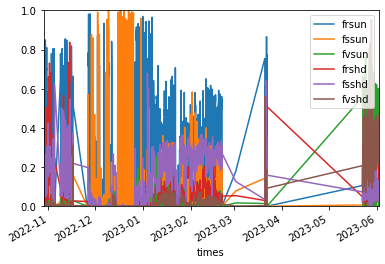

In [126]:
df.plot(x='times',y=['frsun','fssun','fvsun','frshd','fsshd','fvshd'],xlim=[start_dates_cook[0],stop_dates_cook[8]],ylim=[0,1])

<AxesSubplot:xlabel='times'>

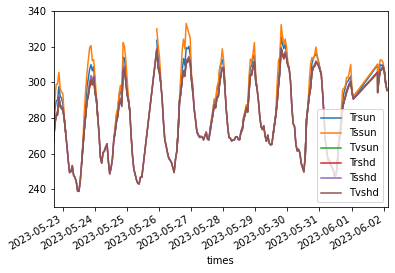

In [130]:
df.plot(x='times',y=['Trsun','Tssun','Tvsun','Trshd','Tsshd','Tvshd'],xlim=[start_dates_cook[6],stop_dates_cook[8]],ylim=[230,340])